# 13 - Reconstructing Zircon Data

This notebook demonstrates how reconstruct and plot point feature data stored in a compressed GPlates Markup Language (GPML) file on a global map through geological time. 

This notebook also demonstrates how to define a plate reconstruction model with `gplately`'s `PlateModelManager`, plot topological plate boundaries, continents, coastlines with an option to plot seafloor age grids if they are available to the user. 

### Exercises completed in this notebook:
1. Plotting point data from a `.gpmlz` file using `gplately`
2. Omitting point data whose positions do not fall on continents (using continent masking);
3. Omitting point data which do not get reconstructed through geological time (for instance they are not properly ascribed a tectonic plate with an associated rotation).

The zircon point data is sourced from:
> __Citation__:
> 1. Wu, Y., Fang, X. and Ji, J., 2023. A global zircon U–Th–Pb geochronological database. Earth System Science Data, 15(11), pp.5171-5181.

In [1]:
# Import all necessary packages
import numpy as np
import glob, os

os.environ["DISABLE_GPLATELY_DEV_WARNING"] = "true"
import gplately
from gplately import pygplates
from plate_model_manager import PlateModelManager

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec

from joblib import Parallel, delayed
from matplotlib.lines import Line2D
import matplotlib

plt.rcParams["font.family"] = "Helvetica"

from scipy.spatial import cKDTree
from rasterio.features import rasterize
from rasterio.transform import from_bounds
import moviepy.editor as mpy

In [2]:
# Obtain all rotation files, topology features and static polygons from Cao2024 via the plate model manager
pm_manager = PlateModelManager()
cao2024_model = pm_manager.get_model("Cao2024", data_dir="plate-model-repo")
rotation_model = cao2024_model.get_rotation_model()
topology_features = cao2024_model.get_topologies()
static_polygons = cao2024_model.get_static_polygons()

# Obtain geometries like continents, coastlines and continent-ocean boundaries (COBs)
coastlines = cao2024_model.get_coastlines()
continents = cao2024_model.get_continental_polygons()
COBs = cao2024_model.get_COBs()
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

time = 1799 #Ma
gplot = gplately.PlotTopologies(model, coastlines=coastlines, continents=continents, COBs=COBs, time=time)

### Define auxiliary functions for plotting the reconstructed data

In [3]:
def latlonticks(ax):
    """A function to plot lon and lat tick labels on the edges of the map.
    """
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False,
              linewidth=1, color='gray', alpha=0.3,)

    ax.text(0.49,-0.03, '60°E', transform=ax.transAxes)
    ax.text(0.46,-0.03, '0°', transform=ax.transAxes)
    ax.text(0.40,-0.025, '60°W', transform=ax.transAxes)
    
    gl.top_labels=False
    gl.bottom_labels=False
    return


def import_cpt(filename, cmap_name="custom_cpt"):
    colors = []
    positions = []

    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()

            # Skip comments or special lines
            if not line or line.startswith('#') or line[0] in ('B', 'F', 'N'):
                continue

            parts = line.split()
            
            try:
                # FORMAT A: Slash-separated RGB like 255/255/0
                if len(parts) == 4 and '/' in parts[1] and '/' in parts[3]:
                    pos1 = float(parts[0])
                    r1, g1, b1 = map(float, parts[1].split('/'))
                    pos2 = float(parts[2])
                    r2, g2, b2 = map(float, parts[3].split('/'))

                # FORMAT B: Space-separated RGB
                elif len(parts) >= 8:
                    pos1 = float(parts[0])
                    r1, g1, b1 = map(float, parts[1:4])
                    pos2 = float(parts[4])
                    r2, g2, b2 = map(float, parts[5:8])
                
                else:
                    # Line format not recognized — skip it
                    continue

                # Add both ends of the segment
                positions.extend([pos1, pos2])
                colors.extend([
                    (r1/255, g1/255, b1/255),
                    (r2/255, g2/255, b2/255)
                ])

            except Exception as e:
                print(f"Skipping malformed line: {line}")
                continue

    if len(positions) == 0:
        raise ValueError("No color stops found in CPT file.")

    # Normalize to [0, 1]
    positions = np.array(positions)
    positions = (positions - positions.min()) / (positions.max() - positions.min())

    return LinearSegmentedColormap.from_list(cmap_name, list(zip(positions, colors)))



## Define and plot 3 colourmaps
1. For zircons
2. For subduction convergence
3. For seafloor age (if provided)

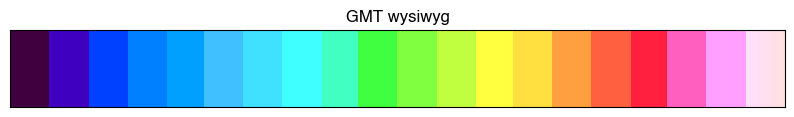

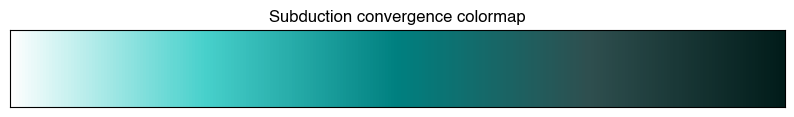

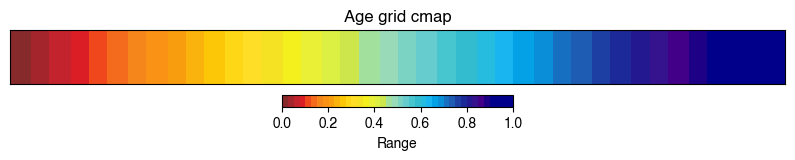

In [4]:
zircon_age_cmap = import_cpt('./NotebookFiles/GMT_wysiwyg.cpt', 'wysiwyg')
custom_cmap = import_cpt('./NotebookFiles/age_1000-0.cpt')

# Also define a convergence colourmap for subduction zone convergence magnitudes later
conv_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'conv_cmap', ['white', 'mediumturquoise', 'teal', 'darkslategray', '#011C1A']
)

plt.figure(figsize=(10, 1))
plt.imshow([np.linspace(0, 1, 256)], aspect='auto', cmap=zircon_age_cmap)
plt.xticks([]); plt.yticks([])
plt.title("GMT wysiwyg")
plt.show()
plt.figure(figsize=(10, 1))
plt.imshow([np.linspace(0, 1, 256)], aspect='auto', cmap=conv_cmap)
plt.xticks([]); plt.yticks([])
plt.title("Subduction convergence colormap")
plt.show()

plt.figure(figsize=(10, 1))
plt.imshow([np.linspace(0, 1, 256)], aspect='auto', cmap=custom_cmap)
plt.xticks([]); plt.yticks([])
plt.colorbar(orientation='horizontal', label='Range')
plt.title("Age grid cmap")
plt.show()

### Define zircon data
The zircon data is stored in a `.gpmlz` file. The positions of the zircons can be reconstructed through time using a function on`gplately`'s `PlateReconstruction` object called `reconstruct()` which we call in the function `reconstruct_deposits` defined below.

In [5]:
# Filenames of zircon data, paths defined relative to this file
zircon_igneous_filename = "./NotebookFiles/zircons_igneous_Wu2023.gpmlz"
zircon_metamorphic_filename = "./NotebookFiles/zircons_metamorphic_Wu2023.gpmlz"
zircon_sedimentary_filename = "./NotebookFiles/zircons_sedimentary_Wu2023.gpmlz"

def reconstruct_deposits(zircon_fname, time):
    """ Reconstruct the coordinates of deposits through time while also keeping track
    of their valid times
    """
    zircon_fc = pygplates.FeatureCollection(zircon_fname)
    
    # RECONSTRUCT ZIRCONS
    reconstructed_features = model.reconstruct(
            zircon_fc, time, from_time=0, anchor_plate_id=0)
    
    curr_lon, curr_lat = gplately.tools.extract_feature_lonlat(reconstructed_features)
        
    fromage = [f.get_feature().get_valid_time()[0] for f in reconstructed_features]
    return curr_lon, curr_lat, fromage



# Example
time = 250
igneous_lon, igneous_lat, igneous_fromage = reconstruct_deposits(zircon_igneous_filename, time)
print(
    "Igneous zircon longitudes at time {}Ma:".format(time), igneous_lon, 
    "\n", "Igneous zircon latitudes at time {}Ma: ".format(time), igneous_lat
)

Igneous zircon longitudes at time 250Ma: [27.36208487 27.37146841 27.38011349 ... 89.01234729 80.60042306
 79.14359335] 
 Igneous zircon latitudes at time 250Ma:  [29.1419412  29.09597609 29.12721955 ... 58.45473787 58.70074717
 49.83244602]


### Define functions to help mask zircon data that are not located over a continent
We use a k-d tree to search for a continent along a radius (km) around each zircon point. If there is no lat-lon point corresponding to a continent we omit the zircon point. 

In [6]:
def get_continent_polygon_coordinates(continent_polygons, resX=0.2, resY=0.2):
    """
    Obtains the latitude and longitude coordinates of continents at the current reconstruction time.
    Assumes 0.2 degree resolution by default
    """
    
    nx, ny = int(360/resX), int(180/resY)

    platforms_grid = rasterize(gplately.geometry.pygplates_to_shapely(continent_polygons),
                               out_shape=(ny,nx),
                               transform=from_bounds(-180, 90, 180, -90, nx, ny))

    xq, yq = np.meshgrid(np.linspace(-180,180,nx),
                         np.linspace(-90, 90, ny))

    mask_grid = platforms_grid > 0
    xcoords = xq[mask_grid]
    ycoords = yq[mask_grid]
    return xcoords, ycoords


def KD_dist(lons0, lats0, lons1, lats1, d_tol):
    """
    Calculate the distance between two sets of lon,lat coordinates - in this notebook we use the
    lons and lats of the zircons and the lons and lats of the continents from get_continent_polygon_coordinates().
    """
    xyz0 = gplately.tools.lonlat2xyz(lons0, lats0, degrees=True)
    xyz1 = gplately.tools.lonlat2xyz(lons1, lats1, degrees=True)
    
    tree = cKDTree(np.c_[xyz0])
    dist, index = tree.query(np.c_[xyz1])
    dist *= 6371
    mask_dist = dist < d_tol
    
    return mask_dist

### Define function to plot zircons over a global map

Seafloor age grids are optional inputs - we do not include them here but the user can pass a filename to the argument `agegrid_fname`.

In [7]:
def plot_zircons(time, agegrid_fname = None, save_fig=False):
    """Plots zircons with plate topological boundaries, plate velocity arrows, continents, coastlines and
    optionally a seafloor age grid.

    If providing an age grid with the timestep in its name, e.g. "./SeafloorAge_2.00Ma.nc" this should be
    formatted like "./SeafloorAge_{:.2f}Ma.nc", where the ":.2f" allows the time to be substituted back into
    the string to 2 decimal places.
    
    """
    # Ensure font is Helvetica
    matplotlib.rcParams['font.family'] = 'Helvetica'

    # Define a matplotlib figure using a cartopy CRS Mollweide projection.
    proj = ccrs.Mollweide(central_longitude=60)
    fig, ax = plt.subplots(1,1, subplot_kw={'projection': proj}, figsize=(12, 7), dpi=150)

    # Set min and max longitude, min and max latitude respectively.
    extent_globe = [-180,180,-90,90]

    # Set the plot title.
    ax.set_title("{} Ma".format(time))

    # ---------- If provided, plot the age grid. -----------------------------------------------------------
    if agegrid_fname:
        agegrid = gplately.Raster(
            agegrid_fname #as an example, grid_directory+"PublishedAgeGrids/Cao2024_SEAFLOOR_AGE_grid_{:.2f}Ma.nc".format(time)
        )
        # Plot all NaNs in the age grid as a grey colour
        cmap = custom_cmap
        cmap.set_bad('0.2',1.)
        # Let the age grid span the globe, with 20% fill opacity, setting min age to 0, max age to 160Ma.
        im = ax.imshow(agegrid.data, extent=extent_globe, cmap=cmap, origin='lower', alpha=0.2,
                   vmin=0, vmax=160, transform=ccrs.PlateCarree(), zorder=1
        )

    # ---------- Plot topologies and coastlines -----------------------------------------------------------

    # IMPORTANT - set gplot.time to current time to automatically rotate all features to the current time
    gplot.time = time

    # Plot plate motion vectors, coastlines, trenches and subduction teeth.
    gplot.plot_plate_motion_vectors(ax, color='0.4', alpha=0.3, zorder=10, regrid_shape=20)
    gplot.plot_coastlines(ax, facecolor='silver', edgecolor='none',)
    gplot.plot_trenches(ax, zorder=9)
    gplot.plot_subduction_teeth(ax, zorder=9)

    
    # ---------- Calculate and plot subduction convergence rates ----------------------------------------
    # We are plotting the plate velocity arrows to show the direction and magnitude of plate motion, as well
    # as subduction teeth to show the direction of subduction and orient which tectonic plate is the subducting and 
    # overriding plate.
    # Split each subduction zone into tessellated points and find the magnitude of subduction convergence.
    trench_data = model.tessellate_subduction_zones(
        time,
        tessellation_threshold_radians=np.radians(0.01),
        anchor_plate_id=0)

    # The 1st, 2nd and 3rd outputs are longitude, latitude and convergence magnitude of the tessellated trench points.
    curr_subd_lon = trench_data[:,0]
    curr_subd_lat = trench_data[:,1]
    curr_subd_convergence = np.clip(trench_data[:,2], 0, 1e99) # Start in cm

    # Plot these lons and lats, colourmapped by subduction convergence and using the colourmap we defined a couple
    # of cells above.
    sc = ax.scatter(curr_subd_lon, curr_subd_lat, c=curr_subd_convergence, cmap=conv_cmap, vmin=0, vmax=14,
        transform=ccrs.PlateCarree(), rasterized=True, 
    )
    # Plot all other topological sections other than trenches or ridges.
    gplot.plot_all_topological_sections(ax, color='grey', tessellate_degrees=1)

    

    # ---------- Reconstruct each zircon type - igneous, sedimentary and metamorphic ----------------------
    igneous_lon, igneous_lat, igneous_fromage = reconstruct_deposits(zircon_igneous_filename, time)
    metamorphic_lon, metamorphic_lat, metamorphic_fromage = reconstruct_deposits(zircon_metamorphic_filename, time)
    sedimentary_lon, sedimentary_lat, sedimentary_fromage = reconstruct_deposits(zircon_sedimentary_filename, time)
    # Turn these into numpy arrays 
    igneous_lon, igneous_lat, igneous_fromage = np.array(igneous_lon), np.array(igneous_lat), np.array(igneous_fromage )
    metamorphic_lon, metamorphic_lat, metamorphic_fromage = np.array(metamorphic_lon), np.array(metamorphic_lat), np.array(metamorphic_fromage)
    sedimentary_lon, sedimentary_lat, sedimentary_fromage = np.array(sedimentary_lon), np.array(sedimentary_lat), np.array(sedimentary_fromage)



    # OMITTING NON-MOVING ZIRCONS, AS WELL AS ZIRCONS THAT DO NOT FALL WITHIN CONTINENTAL BOUNDARIES.

    
    # ---------- Exercise: Omit zircons with no rotation by reconstructing their position at the next recent timestep 
    #            (assume we are rotating from a max time to present day, 1799Ma to 0Ma) and checking
    #            whether the position now equals the position in the next timestep in the future.
    #            However, only do this before 0Ma as there is no future timestep to project towards.
    if time > 0:
        # Reconstruct the zircons' positions in the next future timestep
        future_igneous_lon, future_igneous_lat, future_igneous_fromage = reconstruct_deposits(zircon_igneous_filename, time-1)
        future_metamorphic_lon, future_metamorphic_lat, future_metamorphic_fromage = reconstruct_deposits(zircon_metamorphic_filename, time-1)
        future_sedimentary_lon, future_sedimentary_lat, future_sedimentary_fromage = reconstruct_deposits(zircon_sedimentary_filename, time-1) 
        # Turn these position arrays into numpy arrays so we can perform array masking.
        future_igneous_lon, future_igneous_lat, future_igneous_fromage = np.array(future_igneous_lon), np.array(future_igneous_lat), np.array(future_igneous_fromage )
        future_metamorphic_lon, future_metamorphic_lat, future_metamorphic_fromage = np.array(future_metamorphic_lon), np.array(future_metamorphic_lat), np.array(future_metamorphic_fromage)
        future_sedimentary_lon, future_sedimentary_lat, future_sedimentary_fromage = np.array(future_sedimentary_lon), np.array(future_sedimentary_lat), np.array(future_sedimentary_fromage)

        # All reconstructable zircons are considered to be values in the present-day arrays that are NOT in the future arrays.
        # If they did not move, they'd have identical lats and lons at the current and future timestep.
        # These 3 lines develop a mask with [True, False,...] marking which indices in both arrays do not have identical
        # elements, i.e. which zircons to keep.
        moving_igneous = ~np.isin(igneous_lon, future_igneous_lon)
        moving_sedimentary = ~np.isin(sedimentary_lon, future_sedimentary_lon)
        moving_metamorphic = ~np.isin(metamorphic_lon, future_metamorphic_lon)

        # Collect the subset of original zircon lon, lat and age that are moving using the mask we just made
        igneous_lon, igneous_lat, igneous_fromage = igneous_lon[moving_igneous], igneous_lat[moving_igneous], igneous_fromage[moving_igneous]
        metamorphic_lon, metamorphic_lat, metamorphic_fromage  = metamorphic_lon[moving_metamorphic], metamorphic_lat[moving_metamorphic], metamorphic_fromage[moving_metamorphic]
        sedimentary_lon, sedimentary_lat, sedimentary_fromage = sedimentary_lon[moving_sedimentary], sedimentary_lat[moving_sedimentary], sedimentary_fromage[moving_sedimentary]


    
    # --------- Exercise: Delete zircons that are not deposited on continental boundaries
    #           Here we use continents from the plate model manager and pass this to a function we defined above called
    #           `get_continent_polygon_coordinates`.
    clons, clats = get_continent_polygon_coordinates(
        [f.get_reconstructed_geometry() for f in gplot.continents])

    # Using a tolerance of 100km, use a k-d tree to search which zircons are and are not within 100km radius of any 
    # continental point. Develop a mask - True if within 100km of a continent, false otherwise.
    d_tol = 100
    igneous_in_continent = np.array(KD_dist(clons, clats, igneous_lon, igneous_lat, d_tol))
    sedimentary_in_continent = np.array(KD_dist(clons, clats, sedimentary_lon, sedimentary_lat, d_tol))
    metamorphic_in_continent = np.array(KD_dist(clons, clats, metamorphic_lon, metamorphic_lat, d_tol))
    
    # ------------ PLOT ZIRCONS --------------------------------------------------
    zircon_cmap = zircon_age_cmap

    # Plot the subset of igneous zircons that fall within continents using the mask we just made with the k-d tree
    sc_igneous = ax.scatter(
        igneous_lon[igneous_in_continent], igneous_lat[igneous_in_continent],
        marker="s", c=igneous_fromage[igneous_in_continent], cmap=zircon_cmap, edgecolor='k', 
        s=10,  label="Igneous",
        vmin=0,
        vmax=1800,
        transform=ccrs.PlateCarree(), linewidth=0.3
    )
    # Plot the subset of metamorphic zircons that fall within continents using the mask we just made with the k-d tree
    sc_metamorphic = ax.scatter(
        metamorphic_lon[metamorphic_in_continent], metamorphic_lat[metamorphic_in_continent],
        marker="^", c=metamorphic_fromage[metamorphic_in_continent], cmap=zircon_cmap, edgecolor='k', 
        s=10,  label="Metamorphic",
        vmin=0,
        vmax=1800,
        transform=ccrs.PlateCarree(), linewidth=0.3
    )
    # Plot the subset of sedimentary zircons that fall within continents using the mask we just made with the k-d tree
    sc_sedimentary = ax.scatter(
        sedimentary_lon[sedimentary_in_continent], sedimentary_lat[sedimentary_in_continent],
        marker="o", c=sedimentary_fromage[sedimentary_in_continent], cmap=zircon_cmap, edgecolor='k', 
        s=10,  label="Sedimentary",
        vmin=0,
        vmax=1800,
        transform=ccrs.PlateCarree(), linewidth=0.3
    )
    
    # Show lat lon tick marks using the function we defined a few cells above.
    latlonticks(ax)

    # ---------- Plot colorbars for subduction convergence, seafloor age (if provided) and zircon age --------------
    gs = gridspec.GridSpec(2,2, hspace=0.05, wspace=0.6, height_ratios=[0.96,0.04])

    cax1 = fig.add_axes([0.0, 0.21, 0.25, 0.02])
    cb1 = fig.colorbar(sc,  cax=cax1, ticks=np.arange(0,12.51,2.5), orientation='horizontal', label='Subduction convergence rate (cm/yr)', extend='max')
    cax3 = fig.add_axes([0.6, 0.21, 0.25, 0.02])

    if agegrid_fname:
        cax2 = fig.add_axes([0.3, 0.21, 0.25, 0.02])
        cb2 = fig.colorbar(im,  cax=cax3, orientation='horizontal', label='Seafloor age (Myr)', extend='max')

        #cax4 = fig.add_axes([0.0, 0.10, 0.25, 0.02])
        zircon_cb = fig.colorbar(sc_igneous,  cax=cax2, orientation='horizontal', label='Zircon age (Myr)', extend='max')
    else:
        zircon_cb = fig.colorbar(sc_igneous,  cax=cax3, orientation='horizontal', label='Zircon age (Myr)', extend='max')

    cb1.set_ticklabels(np.arange(0,12.51,2.5))    
    fig.subplots_adjust(bottom=0.25, top=0.95, left=0.05, right=0.80,
                wspace=0.001, hspace=0.3)


    # --------------- LEGEND 
    
    ax.legend(ncols=3, labelspacing=1.3, bbox_to_anchor=(0.72, -0.25))
    ax.set_global()
    
    if save_fig:
        os.makedirs(output_directory+"/zircons", exist_ok=True)
        for out_format in ["png"]:
            fig.savefig(output_directory+"/zircons/zircons_{}Ma.{}".format(save_time, out_format), dpi=300, bbox_inches='tight')
    else:
        plt.show()
        
    plt.close()
    return

## Test `time=0`

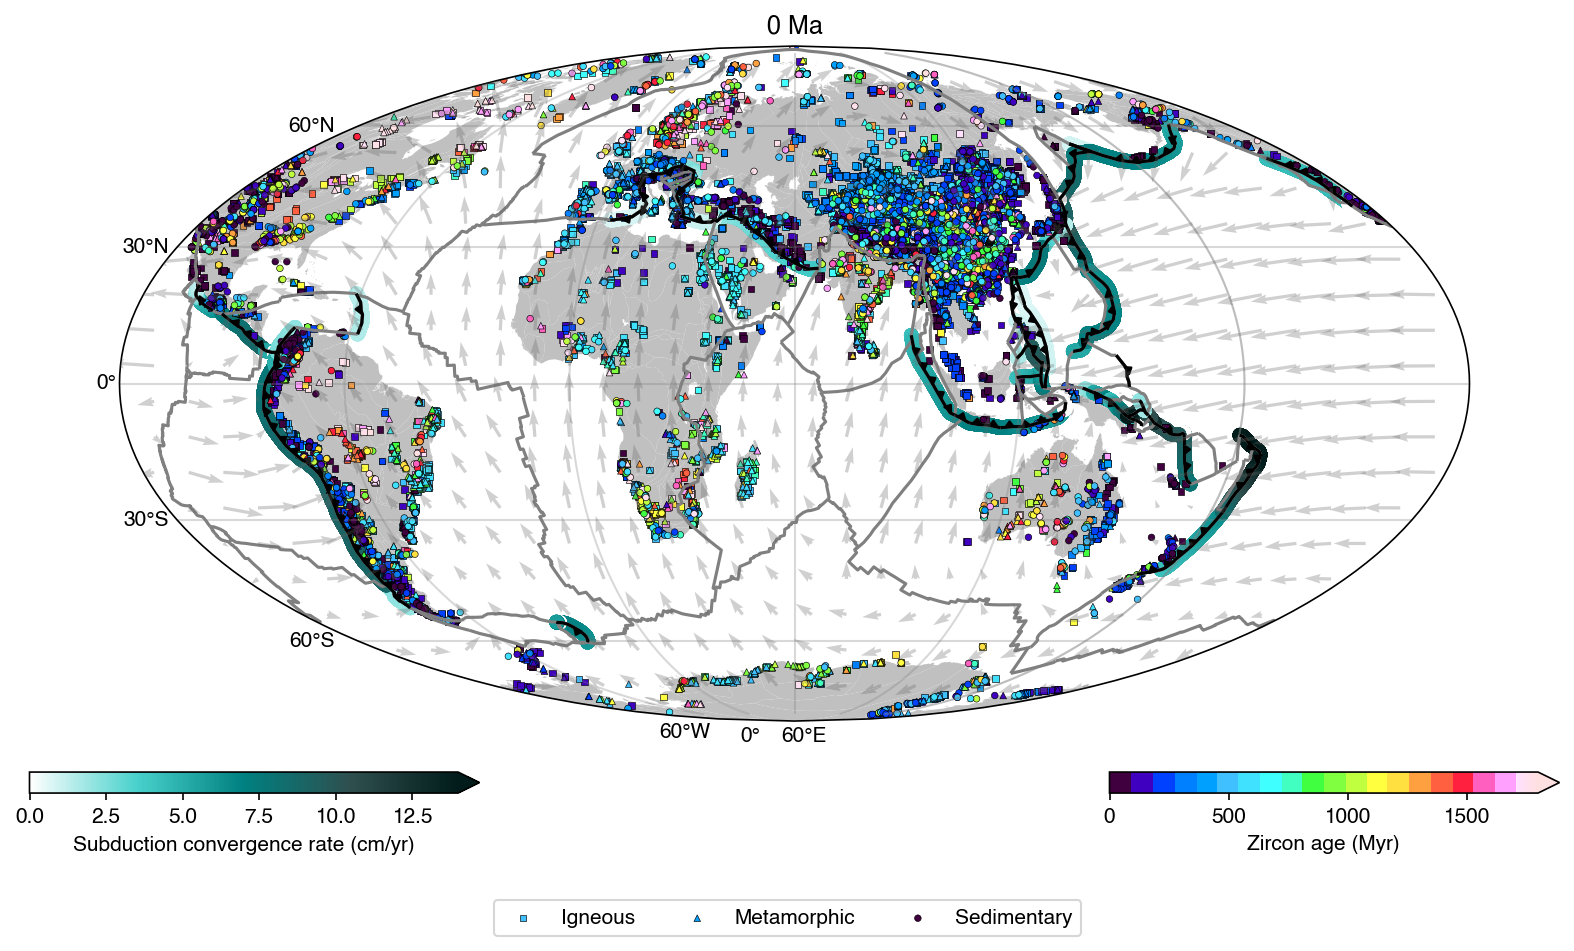

In [8]:
plot_zircons(time=0)

## Test with an agegrid

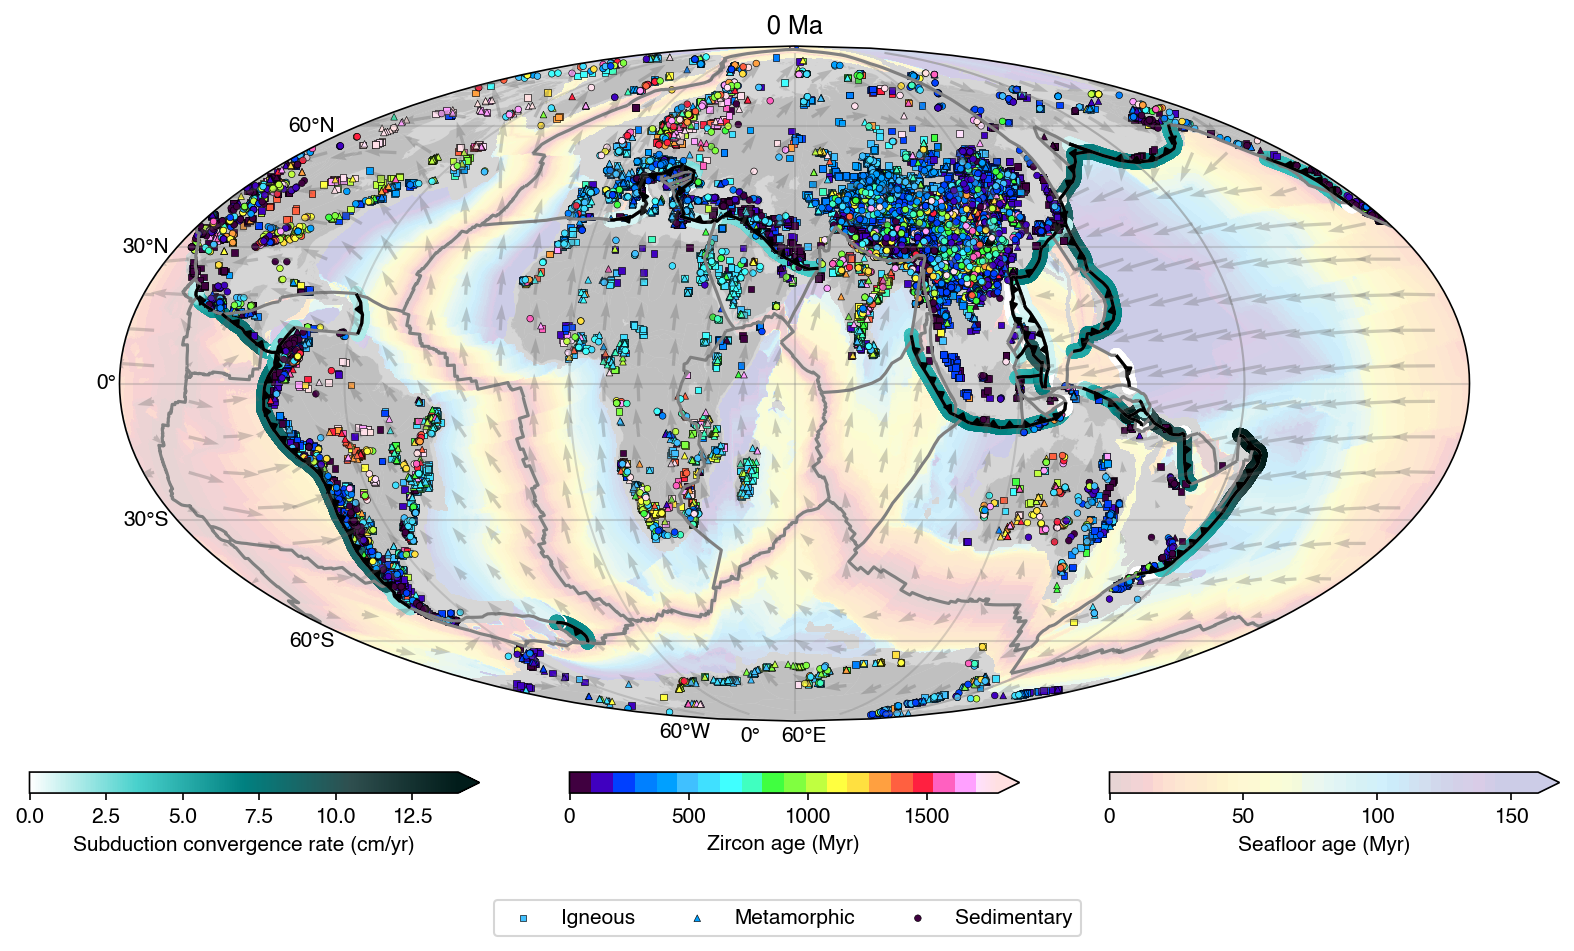

In [9]:
time = 0
plot_zircons(
    time,
    agegrid_fname="./NotebookFiles/Cao2024_SEAFLOOR_AGE_grid_{:.2f}Ma.nc".format(time)
)

# Repeat for all timesteps
In this notebook we demonstrate plotting zircons from 1799-0Ma, the full reconstruction extent of the `Cao2024` model. This is typically done in a `for` loop using an array of times, e.g. `np.arange(1799,-1,-1)`, i.e. starting at 1799Ma up to 0Ma, noting `arange` stops before -1, hence 0.

We also want to save each plot as a `.png` photo so we define an `output_directory` to save the maps to (see below). The plotting function already takes care of the filenames, so only an `output_directory` folder is needed.

### Normal for loops vs. parallelisation
Running this plotting function in 1 for loop for 1799 timesteps can be slow. Instead of running each iteration one after the other, we can distribute them across multiple CPU cores so they can run simultaneously using `joblib`, a Python library. This is possible if the user's system has adequate memory.

Both normal for loops and parallelisation are demonstrated here and can be toggled using the boolean below:

In [10]:
use_parallel = True

output_directory = "./NotebookFiles" # Replace with your save directory here
os.makedirs(output_directory, exist_ok=True)

In [ ]:
if use_parallel:
    # Produce plots in a parallel routine - a progress bar and time taken will be shown.
    parallel_plots = Parallel(n_jobs=-1, verbose=1) \
    (delayed(plot_zircons) \
     (time, save_fig=True) for time in np.arange(1799,-1,-1))

else:
    for time in np.arange(1799,-1,-1):
        plot_zircons(time, save_fig=True)

        # This option won't show a progress bar, so make one here
        if time in np.arange(1700,-1,-100):
            print("{}Ma map plotted and saved.".format(time))

# Turn frames into a video
We now have 1799 frames to collate into a flipbook-style video. We use `moviepy` for this.

In [ ]:
frame_list = []
for time in np.arange(1799,-1,-1):
    frame_list.append(
        output_directory+"/zircons/zircons_{}Ma.{}".format(time, 'png')
    )

clip = mpy.ImageSequenceClip(frame_list, fps=25)

clip.write_videofile(
    output_directory+"/zircons.mp4",
    fps=20,
    codec="libx264",
    bitrate="5000k",
    audio=False,
    logger=None,
    ffmpeg_params=[
        "-vf",
        "pad=ceil(iw/2)*2:ceil(ih/2)*2",
        "-pix_fmt",
        "yuv420p",
    ],
)